# Exploratory Data Analysis
In this analysis, there are a few questions that I would like to explore using the data. These are:
- How are the numerical data distributed and are they any obvious correlations?
- What genres are the most frequently made by anime studios?
- How do the genres an anime is labelled as affect the ratings of the anime?
- How many people has rated at least one anime instead of only watching it and what proportion rate animes?
- For users that do rate animes, what is their average rating they give out?

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.options.display.float_format = '{:,.3f}'.format

## Anime Dataset

In [2]:
# import anime dataset
anime_df = pd.read_csv("datasets/cleaned_anime.csv")
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.000,9.260,793665
1,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.000,9.250,114262
2,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.000,9.170,673572
3,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.000,9.160,151266
4,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10.000,9.150,93351


In [3]:
# how many animes do we have in the dataset now?
print(f"The dataset contains {anime_df.shape[0]} anime shows")

The dataset contains 3787 anime shows


### How are the numerical data distributed and are they any obvious correlations?

In [60]:
# summary statistics
summ_stats = anime_df[["episodes", "rating", "members"]].describe()
mode = anime_df[["episodes", "rating", "members"]].mode()
summ_stats = summ_stats.append(mode)
summ_stats.rename(index={0: "mode"})

,episodes,rating,members
count,"3,578.000","3,671.000","3,787.000"
mean,35.916,6.902,"42,683.658"
std,80.640,0.864,"89,121.009"
min,2.000,2.670,12.000
25%,12.000,6.440,483.000
50%,24.000,6.940,"5,947.000"
75%,39.000,7.460,"44,246.000"
max,"1,818.000",9.600,"1,013,917.000"
mode,12.000,6.500,102.000


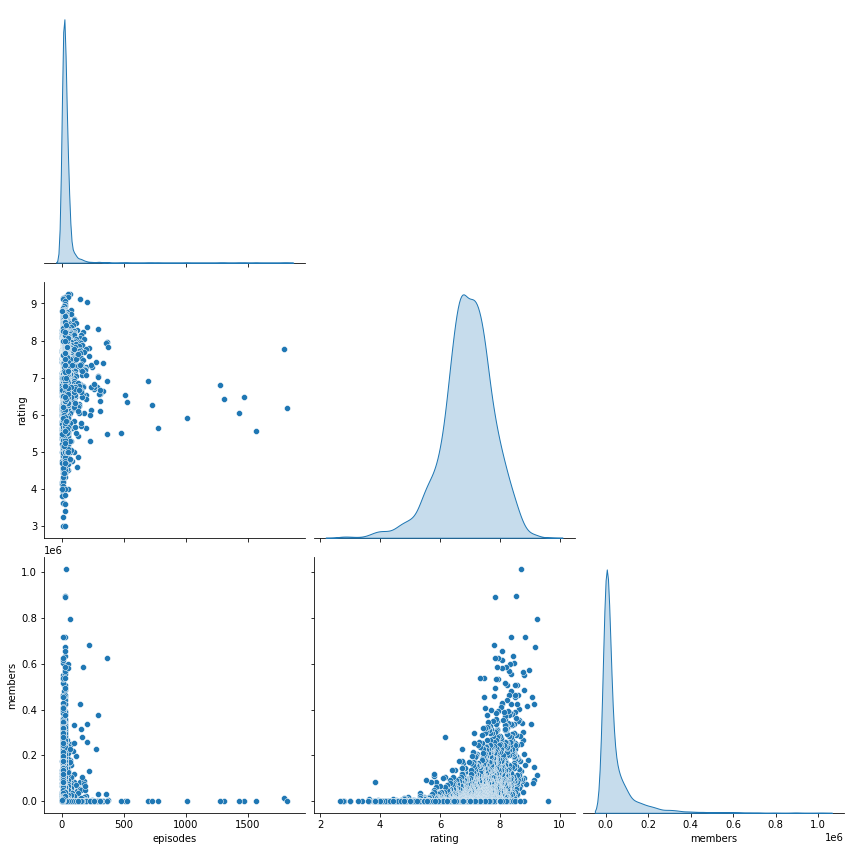

In [6]:
# pairplot
sns.pairplot(data = anime_df, vars=["episodes","rating", "members"], height=4, diag_kind= "kde", corner=True);

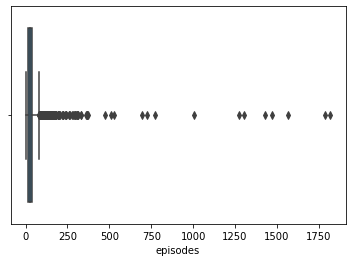

In [7]:
#boxplot of number of episodes
sns.boxplot(data=anime_df, x="episodes");

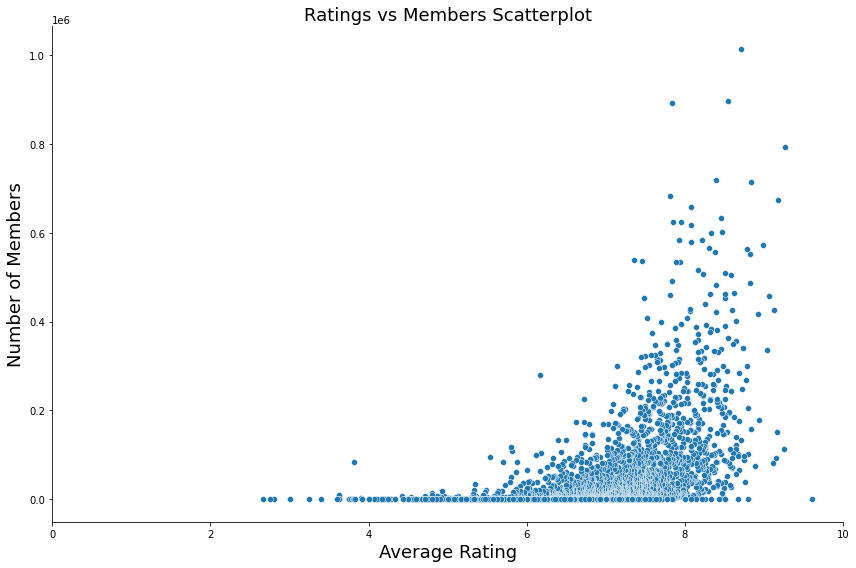

In [8]:
#plot ratings vs members
plt.figure(figsize=(12,8))
sns.scatterplot(data=anime_df, x="rating", y="members")
plt.title("Ratings vs Members Scatterplot", size=18)
plt.xlabel("Average Rating", size=18)
plt.xlim(0, 10)
plt.ylabel("Number of Members", size=18)
sns.despine()
plt.tight_layout()
plt.show()

Looking at the histograms on the pair plot, we see that the distribution of ratings for shows seem to be **slightly left skewed** while the number of members seem to be **heavily right skewed**. These are also supported by the measures of central tendency. For the ratings, we see a **mode of 6**, a **median of 7**, and a **mean of 7**. Although numerically it seems reasonably symmetrically distributed, we say that visually it is quite obviously left skewed. This is most likely because the range of values is very small and so the distribution of the ratings data is not obvious when only using the mean, median, and mode. On the other hand the number of members has a **mode of 102**, **median of 5947**, and a **mean of 42684** justifying the assumption that it is heavily right skewed. The histogram for the number of episodes has extremely low frequencies of animes with high numbers of episodes however, looking at the boxplot and the numerical data, we see that the distribution is **left skewed** with a **mode of 12**, a **median of 24**, and a **mean of 36**.

All three distributions of the numerical data may suggest that some form of transformation may be required before building the recommendation system.

Regarding any correlations, it seems that there are no obvious correlations between the number of episodes and the amount of members, and also there seems to be no clear correlation between number of episodes and their average ratings. There does seem to a possible weak positive exponential relationship between the average rating a show gets compared to the number of members.  

### What genres are the most frequently made by anime studios?

In [9]:
# function to count the freq of animes for each genre
def count_genre_freq(df, column, delimiter=", "):
    from collections import Counter
    non_empty_rows = df[df[column].isnull() == False][column]
    row_counted = non_empty_rows.str.split(delimiter).apply(Counter)
    total_freq = dict(sum(row_counted, Counter()))
    freq_series = pd.Series(total_freq)
    output = freq_series.sort_values(ascending=False)
    return output

In [10]:
# Find total number of animes in the dataset that belong to a certain genre
animes_per_genre = count_genre_freq(anime_df, "genre")
animes_per_genre

Comedy           1870
Action           1098
Adventure         932
Sci-Fi            774
Fantasy           765
Shounen           712
Drama             697
Romance           652
School            567
Slice of Life     562
Kids              484
Supernatural      431
Mecha             379
Magic             353
Shoujo            283
Historical        275
Ecchi             245
Sports            240
Seinen            235
Mystery           222
Super Power       190
Harem             175
Military          133
Parody            126
Space             123
Music             123
Horror            113
Game              103
Martial Arts       95
Demons             89
Psychological      89
Samurai            51
Police             50
Vampire            46
Cars               36
Thriller           34
Josei              32
Shoujo Ai          31
Shounen Ai         24
Dementia            9
dtype: int64

In [11]:
# top 5 most frequent genres
animes_per_genre.head()

Comedy       1870
Action       1098
Adventure     932
Sci-Fi        774
Fantasy       765
dtype: int64

In [12]:
# 5 least frequent genres
animes_per_genre.tail()

Thriller      34
Josei         32
Shoujo Ai     31
Shounen Ai    24
Dementia       9
dtype: int64

It seems as though the 5 most frequent anime genres of the dataset are **Comedy, Action, Adventure, Sci-Fi, and Fantasy** while the genres with the lowest frequencies are **Thriller, Josei, Shoujo Ai, Shounen Ai, and Dementia**.

Let's visualise the numbers in a graph.

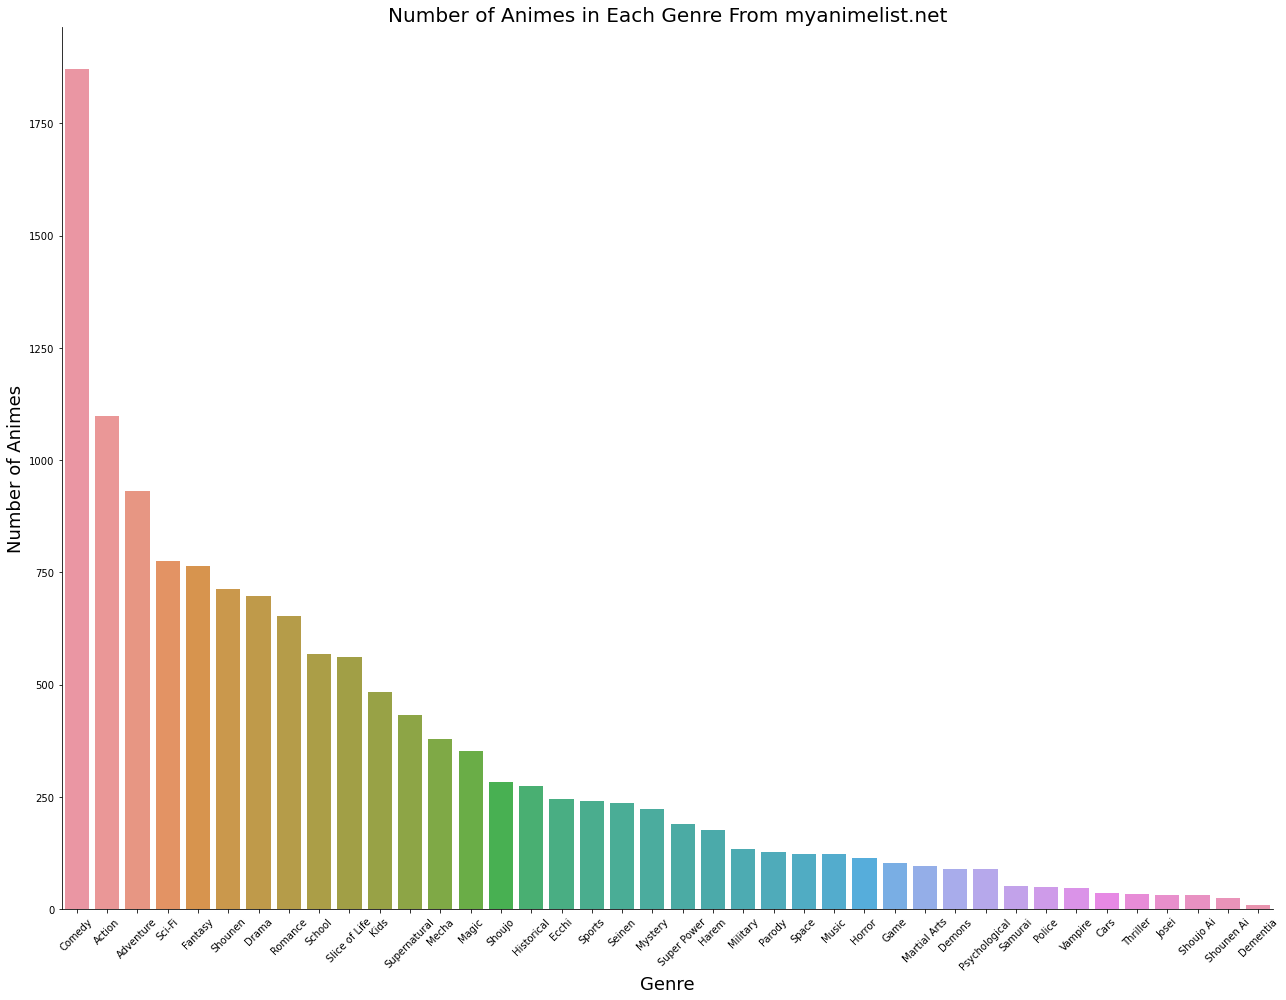

In [13]:
# plot the number of animes per genre
plt.figure(figsize=(18,14))
sns.barplot(x=animes_per_genre.index, y=animes_per_genre.values)
plt.xlabel("Genre", size=18)
plt.ylabel("Number of Animes", size=18)
plt.xticks(rotation=45)
plt.title("Number of Animes in Each Genre From myanimelist.net", size=20)
plt.tight_layout()
sns.despine();

Let's now compare the mean and median ratings for the top 5 most common genres versus the 5 least common genres. First I create a function that outputs the mean and median ratings for a given genre in addition to how many animes are labeled as said genre.

In [14]:
def find_mean_median_rating(df, string):
    # Create new dataframe that contains only the rows where the genre contains the given string and the ratings are not null
    output_df = df[df["genre"].str.contains(string, na=False) & ~np.isnan(df["rating"])]["rating"]
    return output_df.mean(), output_df.median(), output_df.count()


In [15]:
# Create a dictionary to save the information
mmc_dict = {}

After that it's time to input the genres and create a dataframe of the values.

In [16]:
top_5_genres = ["Comedy", "Action", "Adventure", "Sci-Fi", "Fantasy"]
for genre in top_5_genres:
    mean, median, count = find_mean_median_rating(anime_df, genre)
    mmc_dict[genre] = [round(mean, 3), round(median,3), count]

In [17]:
bottom_5_genres = ["Thriller", "Josei", "Shoujo Ai", "Shounen Ai", "Dementia"]
for genre in bottom_5_genres:
    mean, median, count = find_mean_median_rating(anime_df, genre)
    mmc_dict[genre] = [round(mean, 3), round(median,3), count]

In [18]:
# Convert into a dataframe
mmc_df = pd.DataFrame.from_dict(mmc_dict, orient="index", dtype="float", columns=["Mean", "Median", "Count"])

In [19]:
mmc_df

,Mean,Median,Count
Comedy,6.868,6.920,"1,828.000"
Action,7.107,7.130,"1,064.000"
Adventure,6.964,6.950,917.000
Sci-Fi,6.981,6.990,757.000
Fantasy,7.033,7.065,732.000
Thriller,7.886,8.025,34.000
Josei,7.610,7.600,30.000
Shoujo Ai,7.173,7.185,30.000
Shounen Ai,7.192,7.190,23.000
Dementia,7.207,7.210,7.000


I'm going to plot the information as it is hard to compare the values in the dataframe.

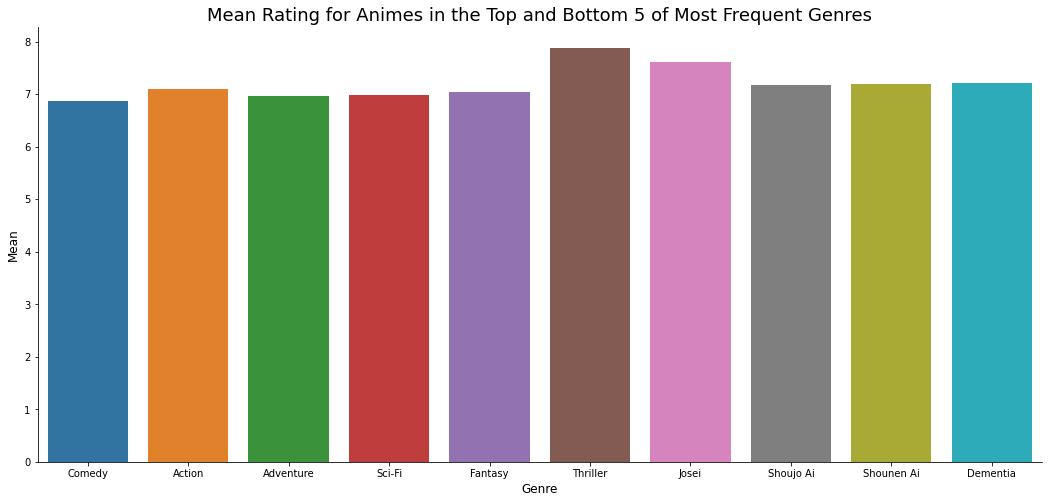

In [107]:
# Plot mean ratings
plt.figure(figsize=(18,8))
sns.barplot(x=mmc_df.index, y=mmc_df["Mean"])
plt.xlabel("Genre", size=12)
plt.ylabel("Mean", size=12)
plt.title("Mean Rating for Animes in the Top and Bottom 5 of Most Frequent Genres", size=18)
sns.despine();

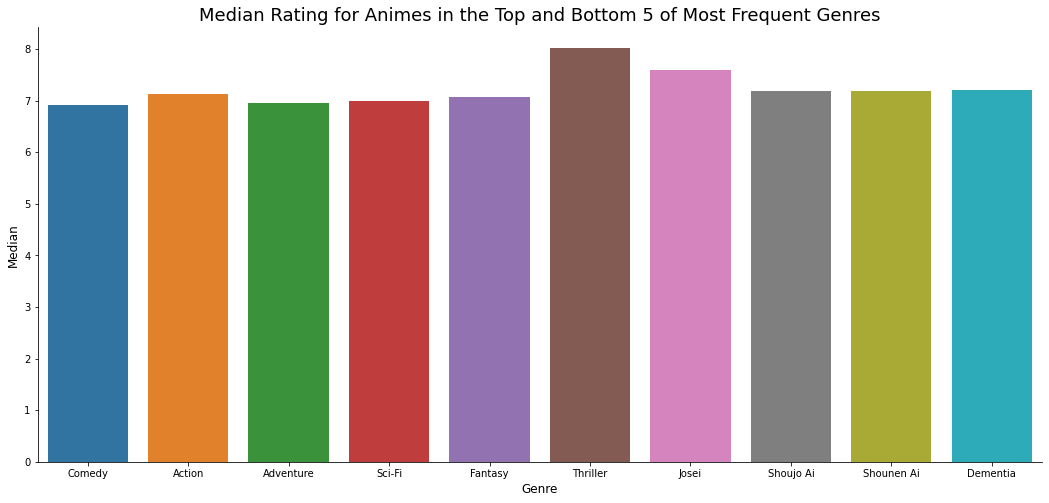

In [108]:
# Plot median ratings
plt.figure(figsize=(18,8))
sns.barplot(x=mmc_df.index, y=mmc_df["Median"])
plt.xlabel("Genre", size=12)
plt.ylabel("Median", size=12)
plt.title("Median Rating for Animes in the Top and Bottom 5 of Most Frequent Genres", size=18)
sns.despine();

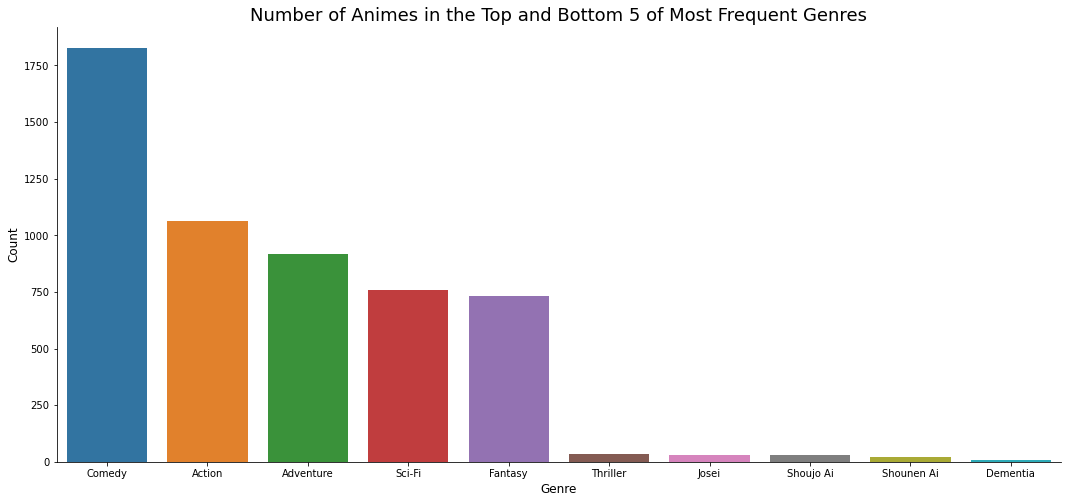

In [109]:
# Plot number of animes in the top
plt.figure(figsize=(18,8))
sns.barplot(x=mmc_df.index, y=mmc_df["Count"])
plt.xlabel("Genre", size=12)
plt.ylabel("Count", size=12)
plt.title("Number of Animes in the Top and Bottom 5 of Most Frequent Genres", size=18)
sns.despine();

Looking at the bar graphs, it seems that all 10 of the genres have similar mean and median ratings of around 7 - 7.3 which is surprising as one may think the more popular anime genres who be rated higher. This may be due to the fact that Thriller, Josei, Shoujo Ai, Shounen Ai, and Dementia all have relatively tiny number of animes made and so the ratings may not reflect the true popularity of the genres.

## Ratings Dataset

Before we go answering the questions related to the ratings dataset, let's first explore it a bit more generally to see if we can find anything interesting.
- How many people rate an anime instead of only watching it and what proportion rate animes? 
- For users that do rate animes, what is their average rating they give out?

In [23]:
# Load rating dataset
rating_df = pd.read_csv("datasets/cleaned_rating.csv")
rating_df.head(10)

,user_id,anime_id,rating
0,1,20,nan
1,1,24,nan
2,1,79,nan
3,1,226,nan
4,1,241,nan
5,1,355,nan
6,1,356,nan
7,1,442,nan
8,1,487,nan
9,1,846,nan


From what we can see from the preview of the dataset, it seems as though this dataset may contain a lot of data where a user watched an anime show, but did not give it a rating. This is represented by the "nan" in the rating column which we previously replace "-1" with in the initial data cleaning. First I would like to see how many rows of data we have in total, and then try find how many rows contain a rating to eventually find the difference.

In [24]:
# How many rows of data do we have?
print(f"In total, there are {rating_df.shape[0]} rows of data")

In total, there are 7813737 rows of data


In [25]:
# How many rows contain a rating value?
print(f"There are {rating_df[rating_df.rating.notnull()].shape[0]} rows that have ratings")

There are 6337241 rows that have ratings


In [26]:
# How many rows have empty ratings?
print(f"This means there are {rating_df[rating_df.rating.isnull()].shape[0]} rows that do not have ratings")

This means there are 1476496 rows that do not have ratings


In [27]:
rating_df[["rating"]].describe()

,rating
count,"6,337,241.000"
mean,7.808
std,1.572
min,1.000
25%,7.000
50%,8.000
75%,9.000
max,10.000


### How many people have rated at least one anime instead of only watching it and what proportion rate animes?
To answer this, we need the total amount of users (based on "user_id") and the number of unique users that have rated an anime.

In [29]:
# Find total amount of users
total_num_users = rating_df["user_id"].nunique()
print(f"Total number of users: {total_num_users}")

Total number of users: 73515


In [30]:
# Number of unique users that have rated an anime before
rated_before_users = rating_df[rating_df["rating"].notnull()]["user_id"].nunique()
print(f"Number of users who have rated before: {rated_before_users}")

Number of users who have rated before: 69600


In [31]:
# Proportion of people who have rated at least one anime
prop_rated = rated_before_users/total_num_users * 100
print(f"The proportion of people who have rated at least one anime on MyAnimeList is {prop_rated:.2f}%")

The proportion of people who have rated at least one anime on MyAnimeList is 94.67%


So what we see from the 94.67% is that the vast majority of user's have rated an anime before which is not surprising. One thing from this question that I would like to investigate further is the actual frequencies that people rate anime at. What would also be interesting to look at is what proportion of people consistently rate animes they've watched (say at least 75% of animes watched).

### Frequencies of Ratings per User

In [70]:
# First create a new dataframe that contains the user_id and the number of animes rated
rating_freq = rating_df.groupby("user_id")[["rating"]].count()
rating_freq.rename({"rating": "num_animes_rated"}, axis="columns", inplace=True)
rating_freq

,num_animes_rated
user_id,
1,4
2,1
3,92
4,0
5,459
...,...
73512,12
73513,33
73514,1


In [72]:
# Summary statistics
rating_freq.describe()

,num_animes_rated
count,"73,515.000"
mean,86.203
std,133.673
min,0.000
25%,9.000
50%,40.000
75%,108.000
max,"3,747.000"


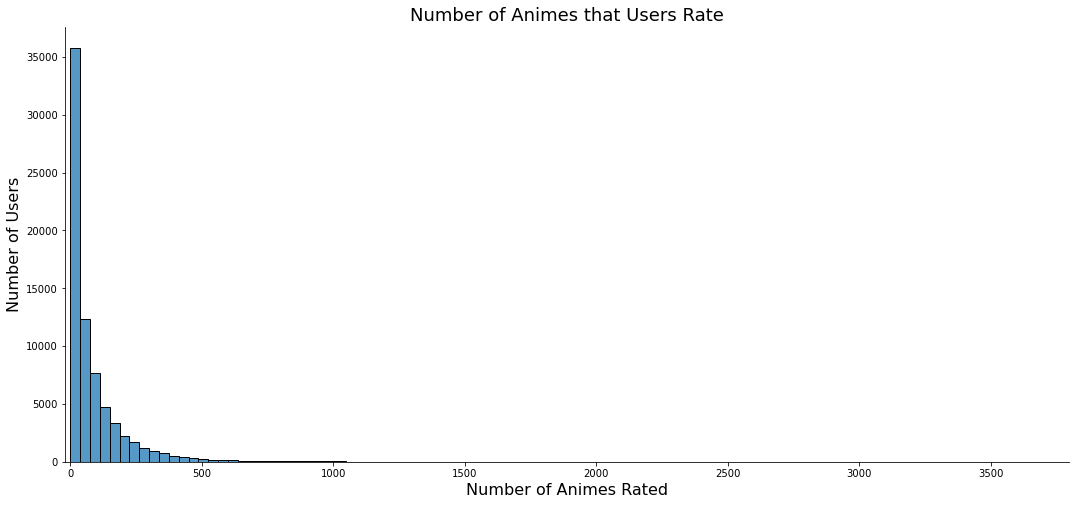

In [143]:
plt.figure(figsize=(18,8))
plt.xlim(left=-20, right=3800)
plt.xlabel("Number of Animes Rated",size=16)
plt.ylabel("Number of Users", size=16)
plt.title("Number of Animes that Users Rate", size=18)
sns.histplot(data=rating_freq.dropna(), x="num_animes_rated", bins=100)
sns.despine();

### For users that do rate animes, what is their average rating they give out?

In [32]:
rating_df[rating_df["user_id"]==1]["rating"].mean(skipna=False)

nan

In [33]:
rating_df[rating_df["user_id"]==1 & rating_df["rating"].notnull()]["rating"]

47    10.000
81    10.000
83    10.000
101   10.000
Name: rating, dtype: float64

In [34]:
rating_df.groupby("user_id")["rating"].agg(["mean","median"], drop_na=True)

,mean,median
user_id,,
1,10.000,10.000
2,10.000,10.000
3,7.565,7.000
4,nan,nan
5,4.355,5.000
...,...,...
73512,8.583,8.500
73513,7.515,8.000
73514,10.000,10.000


In [35]:
rating_df.groupby("user_id")["rating"].agg(["mean","median"], skipna=False)

,mean,median
user_id,,
1,10.000,10.000
2,10.000,10.000
3,7.565,7.000
4,nan,nan
5,4.355,5.000
...,...,...
73512,8.583,8.500
73513,7.515,8.000
73514,10.000,10.000


In [36]:
rating_df["rating"].isnull()

0           True
1           True
2           True
3           True
4           True
           ...  
7813732    False
7813733    False
7813734    False
7813735    False
7813736    False
Name: rating, Length: 7813737, dtype: bool